In [1]:
#import libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import initializers
from keras.utils.generic_utils import get_custom_objects

In [6]:
# define error activation function
def custom_activation(x):
    
    return tf.math.erf(x/(tf.sqrt(2.*N)))
    
get_custom_objects().update({'custom_activation': Activation(custom_activation)})

#define teacher neural network 

def teacher_SCM(N,M):
"""
In: N: input-layer size
    M: hidden-layer size
       
Out:  teacher neural network -> tensorflow model

"""
    teacher=tf.keras.models.Sequential([
                                  
    tf.keras.layers.Flatten(input_shape=(N,),name="layer0"),

    

    tf.keras.layers.Dense(M,activation=custom_activation,name="layer1",use_bias=False,kernel_initializer=initializers.RandomNormal(mean=0,stddev=1))])

    out=tf.keras.layers.Dense(1, activation=None,name="layerout",use_bias=False,kernel_initializer=initializers.RandomNormal(stddev=0,mean=1))
    out.trainable=False
    teacher.add(out)
    teacher.compile(
        optimizer=tf.keras.optimizers.SGD(1),
        loss=my_loss_fn,
        metrics=None,
   
    )
    
    new_weights=np.zeros((N,M))
    
    for i in range(0,M):
    
       new_weights[:,i]=teacher.weights[0].numpy()[:,i]/np.linalg.norm(teacher.weights[0].numpy()[:,i])*np.sqrt(N)


    b=[]
    
    b.append(new_weights)
    b.append(teacher.weights[1].numpy())

    
    teacher.set_weights(b)
    
    return teacher



def student_out(N,K,M):
    
"""
In: N: input-layer size
    K: hidden-layer size of student
    M: hidden-layer size of teacher (here not necessary)
       
Out:  student neural network -> tensorflow model

"""
    
    #,seed=13
    student=tf.keras.models.Sequential([
                                  
    tf.keras.layers.Flatten(input_shape=(N,),name="layer0")])
    
    hidden=tf.keras.layers.Dense(K,activation=custom_activation,name="layer1",use_bias=False,
    bias_initializer=initializers.Zeros(),
    kernel_initializer=initializers.random_normal(stddev=1.,mean=0))
    hidden1=tf.keras.layers.Dense(K,activation=custom_activation,name="layer1",
                use_bias=False,kernel_initializer=initializers.orthogonal(gain=np.sqrt(N),seed=None))
    hidden.trainable=False
    hidden1.trainable=False
    student.add(hidden)
    out=tf.keras.layers.Dense(1, 
    activation=None,name="layerout",use_bias=False,kernel_initializer=initializers.RandomNormal(stddev=1/np.sqrt(K),mean=0))
    out.trainable=True
    student.add(out)
    student.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss=my_loss_fn,
        metrics=None,
   
    )
    
    # normalize student vectors at initialization
    
    new_weights=np.zeros((N,K))
    
    for i in range(0,K):
    
       new_weights[:,i]=student.weights[0].numpy()[:,i]/np.linalg.norm(student.weights[0].numpy()[:,i])*np.sqrt(N)


    b=[]
    
    b.append(new_weights)
    b.append(student.weights[1].numpy())

    
    student.set_weights(b)

    return student

In [35]:
def lin(l,N,M=1,loop=10):
    
"""
 Calculate numerically the asymptotic generalization error according to Equation 14 given in the Paper for different
 hidden-layer sizes K 
 
In: N: input-layer size
    l: list of different student hidden-layer sizes
    M: hidden-layer size of teacher (here not necessary)
    loop: number of different initializations
       
Out:  eg: mean value of asymptotic generalization error
     std: standard deviation of asymptotic generalization error due to different initializations
     ac: not necessary here
     bc: not necessary here

"""
    
    ac=[]
    bc=[]
    eg=[]
    
    std=[]
    val2=[]
    
    for i in range(loop):
        aac=[]
        egg=[]
        
        
        bbc=[]
        
        print(i)
        for K in l:
        
        # define correlation matrices Q, and R for a specific K and initialization
        # the matrices Q and R are based on the student and teacher vectors
        
            #initialize student vectors
            kernel_initializer=initializers.RandomNormal(stddev=1.,mean=0)
            s=kernel_initializer((K,N)).numpy()
            
            #normalize student vectors for sqrt(N) length
            for i in range(len(s)):
    
                s[i]=s[i]/np.linalg.norm(s[i])*np.sqrt(N)
        
        
            #initialize teacher vector
            kernel_initializer=initializers.RandomNormal(stddev=1.,mean=0)
            t=kernel_initializer((M,N)).numpy()
            for n in range(M):
    
                t[n]=t[n]/np.linalg.norm(t[n])*np.sqrt(N)

            
            Q=np.full((K,K),1.)
            
            for o in range(K):
                for j in range(o):
        
                    
                    Q[o,j]=np.matmul(s[o],s[j])/N
                    
                
                    Q[j,o]=Q[o,j]
                
         
            
            R=[]
            for o in range(K):
                for n in range(M):
            
                    R.append(np.matmul(s[o],t[n])/N)
            
            
            R=np.array(R)
            z2=[]
            for i in range(K):
                z2.append(np.pi/3-1)
            I2=np.diag(z2,k=0)
            
            #define matrix S given in the paper for the linearized hidden-layer activations
            S=Q+I2
            
            
            eig1, vec1 = np.linalg.eig(S)
            aac.append(np.sum(1/eig1[N:]*(np.matmul(vec1.T,R)**2)[N:]))
            
            bbc.append(np.sum(1/eig1[:N]*(np.matmul(vec1.T,R)**2)[:N]))
            
            # save generalization error for each K
            # calculate asymptotic generalization error according to Equation 14 given in the Paper
            
            egg.append((np.pi/3-np.matmul(R.T,np.matmul(np.matmul(vec1,np.matmul(np.diag(1/eig1),vec1.T)),R)))/(np.pi*2))
            print(K)
            
        
        
        ac.append(np.array(aac))
        bc.append(np.array(bbc))
        # save generalization error for each loop
        eg.append(np.array(egg))
        
        
    
    
    
    bc=np.mean(np.array(bc),axis=0)
    ac=np.mean(np.array(ac),axis=0)
    # average of generalization error of different loops and its standard deviation
    eg=np.mean(np.array(eg),axis=0)
    std=np.std(np.array(eg),axis=0)
    
    return ac,bc,eg,std


In [36]:
l=np.array([250,500,750,1000,1250,1500,1750,2000])

In [37]:
aa,bb,eg2,std=lin(l,200,1,10)

0
250
500
750
1000
1250
1500
1750
2000
1
250
500
750
1000
1250
1500
1750
2000
2
250
500
750
1000
1250
1500
1750
2000
3
250
500
750
1000
1250
1500
1750
2000
4
250
500
750
1000
1250
1500
1750
2000
5
250
500
750
1000
1250
1500
1750
2000
6
250
500
750
1000
1250
1500
1750
2000
7
250
500
750
1000
1250
1500
1750
2000
8
250
500
750
1000
1250
1500
1750
2000
9
250
500
750
1000
1250
1500
1750
2000


In [39]:
#see sage implementation for derivation
"""
Define analytical result for the asymptotic generalization error according to Equation 18 given in the Paper for different
 hidden-layer sizes K and input sizes N
"""

def function(l,N):
    c=np.pi/3-1
    a=1/2*(l/N+1+c-np.sqrt((l/N-1)**2+2*c*(l/N+1)+c**2))
    return 1/(2*np.pi)*(np.pi/3-a)

In [31]:
l2=np.linspace(250,2000,1000)

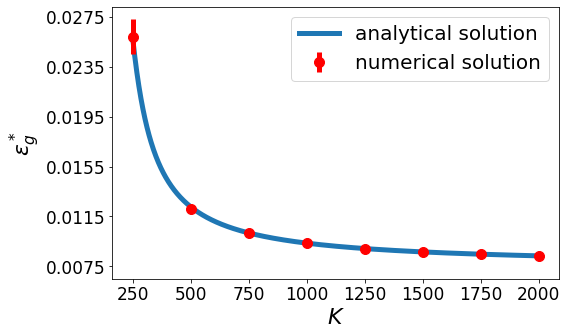

In [63]:
"""
compare simulations with analytical results
"""

ax=plt.figure(figsize=(8,5))
ax.patch.set_alpha(0)
#plt.ylim(-0.0001,0.13)
plt.errorbar(l,eg2,yerr=std,linewidth=5,color="red",zorder=10,fmt="o",markersize=10)
plt.plot(l2,function(l2,200),linewidth=5,linestyle="-")

plt.xlabel(r"$K$",size=22)
plt.ylabel(r"$\epsilon_g^*$",size=22)
plt.yticks([0.0275,0.0235,0.0195,0.0155,0.0075,0.0115],size=17)
plt.xticks(size=17)
plt.ylim(0.0065)
plt.legend(["analytical solution","numerical solution"],fontsize=20)
#plt.savefig("",bbox_inches="tight")
plt.show();
